<a href="https://colab.research.google.com/github/cluePrints/fastai-v3-notes/blob/master/fast_ai3_lesson_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import tensorflow as tf
device = tf.test.gpu_device_name()
assert 'GPU' in device, "Expected device ({device}) to be GPU. Please follow Runtime > Change runtime type > GPU".format(device=device)

In [0]:
!pip install fastai pandas sklearn numpy pillow -q

In [37]:
# so this is fastai==1.0.41
!pip freeze

absl-py==0.7.0
alabaster==0.7.12
albumentations==0.1.11
altair==2.3.0
astor==0.7.1
astropy==3.0.5
atari-py==0.1.7
atomicwrites==1.2.1
attrs==18.2.0
audioread==2.1.6
autograd==1.2
Babel==2.6.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
bokeh==1.0.4
boto==2.49.0
boto3==1.9.84
botocore==1.12.84
Bottleneck==1.2.1
bs4==0.0.1
bz2file==0.98
cachetools==3.0.0
certifi==2018.11.29
cffi==1.11.5
chainer==5.0.0
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
cmake==3.12.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.1.3
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.14.6
cupy-cuda92==5.0.0
cvxopt==1.2.2
cvxpy==1.0.14
cycler==0.10.0
cymem==2.0.2
Cython==0.29.3
cytoolz==0.9.0.1
daft==0.0.4
dask==0.20.2
dataclasses==0.6
datascience==0.10.6
decorator==4.3.2
defusedxml==0.5.0
dill==0.2.9
distributed==1.25.2
Django==2.1.5
dlib==19.16.0
dm-sonnet==1.23
docopt==0.6.2
docutils==0.14
dopamine-rl==1.0.5
easydict==1.9
ecos==2.0.7.pos

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
from os import *
from google.colab import files
if not path.exists("kaggle.json"):
  uploaded = files.upload()
  kaggle_json = list(filter(lambda f: f == 'kaggle.json', uploaded))
  if (len(kaggle_json) == 0):
    raise ValueError("Upload should contain your kaggle.json")
    
!chmod 600 ./kaggle.json

In [0]:
!pip install kaggle pydicom -q

In [41]:
!mkdir -p images

mkdir: cannot create directory ‘images’: File exists


In [0]:
!ls images/*.dcm > /dev/null || KAGGLE_CONFIG_DIR=. kaggle competitions download -c rsna-pneumonia-detection-challenge --quiet

In [0]:
!ls images/*.dcm > /dev/null || for file in $(ls *.zip); do unzip -q $file; done
!ls images/*.dcm > /dev/null || mv *.dcm images

In [44]:
df = pd.read_csv("stage_2_detailed_class_info.csv")
df.count()

patientId    30227
class        30227
dtype: int64

In [45]:
counted = df.groupby('patientId').count()
len(counted[counted['class'] > 1])

3398

In [46]:
df = df.groupby('patientId').max()
# Note to self: by selecting only 1 example per patient we prevent test/train to share the data
counted = df.groupby('patientId').count()
len(counted[counted['class'] > 1])

0

In [0]:
sample_df = df.sample(1000, random_state=42)
sample_df.to_csv('stage_2_detailed_class_info_SUBSET.csv', index=True)

In [48]:
!head stage_2_detailed_class_info_SUBSET.csv

patientId,class
6a4d75d0-51ae-4952-ad56-132474a2cf7b,Lung Opacity
99ad8a84-90fd-460a-9818-263eab12ea0a,No Lung Opacity / Not Normal
e01ef6c8-20f4-48a3-8917-686da0e5b454,Lung Opacity
38f85ed5-7251-48e9-8c52-234be2e3f9f9,Normal
93c3cc21-67cb-44e7-bf5f-483c9168a52b,Normal
f62488bf-6241-453e-af87-c7649ec75780,Normal
3bd6f6e0-c07a-4c22-87e7-53d60de9ad0e,Lung Opacity
08f095ca-158b-4c84-81c1-8f2cd7e20184,No Lung Opacity / Not Normal
88202379-2c7f-4aca-b976-dde9aca06e89,No Lung Opacity / Not Normal


In [0]:
# solution from https://forums.fast.ai/t/dcm-support-in-fastai-v1/27198/7
from fastai.vision import Image
from fastai.vision import pil2tensor
from pydicom import dcmread
import PIL

def open_dcm_image(fn, convert_mode)->Image:
    "Return `Image` object created from image in file `fn`."
    # TODO: take care of convert_mode maybe
    array = dcmread(fn).pixel_array
    x = PIL.Image.fromarray(array).convert('RGB')
    # TODO: see if float32 here actually changes anything
    return Image(pil2tensor(x,np.float32).div_(255))
vision.data.open_image = open_dcm_image

In [0]:
# Note to self: using default size gets error
# CUDA out of memory. Tried to allocate 2.00 GiB (GPU 0; 11.17 GiB total capacity; 9.91 GiB already allocated; 296.19 MiB free; 617.54 MiB cached), restarting the runtime
data_sample = ImageDataBunch.from_csv(csv_labels='stage_2_detailed_class_info_SUBSET.csv', path=".", suffix='.dcm', folder='images', size=224)

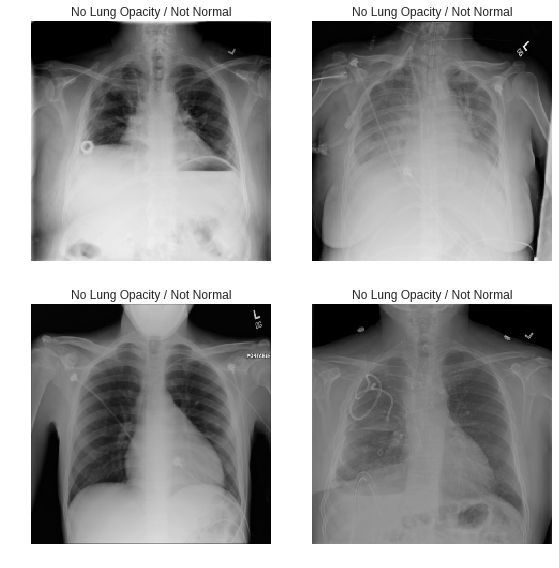

In [51]:
# TODO: rows=1 is throwing an exception - submit a fix, cols=1 is ignored
data_sample.show_batch(rows=2, cols=1)

In [52]:
# Note to self: there's no space being default label delimiter so we've got 3 classes and not 6 = improvement over v0.7.0
data_sample.classes

['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal']

In [0]:
# Note to self: models are not in the default namespace now
learner = create_cnn(data_sample, models.resnet34, metrics=[accuracy])

In [54]:
learner.lr_find(1e-5, 100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


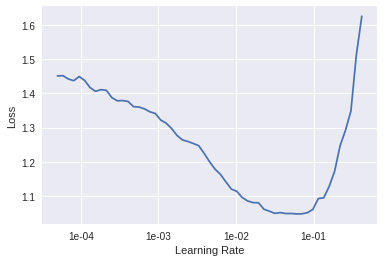

In [58]:
learner.recorder.plot()

In [0]:
from fastai.callbacks.tracker import SaveModelCallback
save_model = SaveModelCallback(learner, name='v1')

In [72]:
learner.fit_one_cycle(10, max_lr=0.05, callbacks=[save_model])

epoch,train_loss,valid_loss,accuracy
1,1.304382,1.275903,0.465000
2,1.097230,2.374076,0.375000
3,1.112896,1.578534,0.575000
4,1.131827,5.360549,0.330000
5,1.093746,1.039183,0.590000
6,1.016672,1.715435,0.435000
7,0.928382,1.027188,0.560000
8,0.834552,0.939745,0.630000
9,0.740073,0.813766,0.635000
10,0.653733,0.802050,0.635000


In [0]:
learner = learner.load('v1')

In [0]:
interpretation = ClassificationInterpretation.from_learner(learner)

In [76]:
# normal & lung opacity are not confused
interpretation.most_confused()

[('Lung Opacity', 'No Lung Opacity / Not Normal', 29),
 ('Normal', 'No Lung Opacity / Not Normal', 17),
 ('No Lung Opacity / Not Normal', 'Normal', 15),
 ('No Lung Opacity / Not Normal', 'Lung Opacity', 10)]